In [154]:
library(httr)
library(jsonlite)
library(tidyr)
library(dplyr)
library(lubridate)
library(ggplot2)
library(ggthemes)
library(RColorBrewer)
library(scales)
library(lubridate)

In [245]:
# check input date is valid
validate_date_range <- function(from_date, to_date){
    tryCatch({
        from_date = as.Date(from_date)
        to_date = as.Date(to_date)
        
        # input date cannot earlier than 20180511(API will not give response)
        min_allowed_date <- as.Date("2018-05-11")
        if (from_date < min_allowed_date || to_date < min_allowed_date) {
            stop("Error: from_date and to_date cannot be earlier than May 11, 2018.")
        }
        
        days_difference <- as.numeric(difftime(to_date, from_date, units = "days"))
        
        if (to_date < from_date) {
            stop("Error: to_date must be greater than or equal to from_date")
        } else if (from_date > Sys.Date()) {
            stop("from_date cannot be in the future.")
        } else if (to_date > Sys.Date()) {
            stop("to_date cannot be in the future.")
        } else if (days_difference > 30){
            stop("Date range cannot exceed 30 days.")
        }
        return(c(from_date = from_date, to_date = to_date))
        
    }, error = function(e) {
        cat("Error converting dates:", e$message, "\n")
        return(c(from_date = NULL, to_date = NULL))
    })
    
}

In [246]:
# get dataframe of carbon generation mix
carbon_generation <- function(from_date, to_date){
    domain = 'https://api.carbonintensity.org.uk/generation'
    
    dates <- validate_date_range(from_date, to_date)
    if (!is.null(dates)) {
        from_date = dates[[1]]
        to_date = dates[[2]]
        cat("Valid date range. Proceeding with API request.\n")
        
        # transfer from_date and to_date
        from_date <- format(from_date, "%Y-%m-%dT%H:%M:00Z")
        from_date <- as.POSIXct(from_date, tz = "UTC") + minutes(30)
        from_date <- format(from_date, "%Y-%m-%dT%H:%M:00Z")
        
        to_date <- format(to_date, "%Y-%m-%dT%H:%M:00Z")
        to_date <- as.POSIXct(to_date, tz = "UTC") + days(1) - minutes(30)
        to_date <- format(to_date, "%Y-%m-%dT%H:%M:00Z")
        
        api_url <- paste0(domain, "/", from_date, "/", to_date)
        #cat(api_url)
        
        response = GET(api_url)
        json_content = content(response, "text",encoding = "UTF-8")
        data <- fromJSON(json_content)$data
        
        json_content = content(response, "text",encoding = "UTF-8")
        data <- fromJSON(json_content)$data
        data <- unnest(data, cols = generationmix)
        data <- spread(data, key = fuel, value = perc)

        data$from <- as.POSIXct(data$from, format = "%Y-%m-%dT%H:%MZ")
        data$to <- as.POSIXct(data$to, format = "%Y-%m-%dT%H:%MZ")
        data$from <- floor_date(data$from, unit = "day")
        data$to <- floor_date(data$to, unit = "day")

        data <- select(data, -from)
        data <- rename(data, date = to)

        data_generation <- data %>%
          group_by(date) %>%
          summarize(
            biomass = sum(biomass),
            coal = sum(coal),
            gas = sum(gas),
            hydro = sum(hydro),
            imports = sum(imports),
            nuclear = sum(nuclear),
            other = sum(other),
            solar = sum(solar),
            wind = sum(wind)
          )
        data_generation
    } 
}

In [291]:
carbon_generation_visual <- function(from_date, to_date, chart_type){
    # valid chart type: "line", "stack", "pie"
    
    data_generation <- carbon_generation(from_date, to_date)
    df_long <- data_generation %>%
      pivot_longer(cols = -date, names_to = "fuel", values_to = "value")
    
    chart_type <- tolower(chart_type)
    if (chart_type == "line"){
        generation_line <- ggplot(df_long, aes(x = date, y = value,color = fuel)) + geom_line() + geom_point() + theme_stata()
        generation_line
    } else if (chart_type == "stack"){
        generation_stack <- ggplot(df_long, aes(x = date, y = value,fill = fuel)) + 
            geom_area() + 
            theme_stata() + 
            scale_fill_brewer(palette="Greens")
        generation_stack
    } else if (chart_type == "pie"){
        df_colSum <- colSums(data_generation[, -1], na.rm = TRUE)
        df_colSum <- as.data.frame(t(df_colSum))
        df_colSum_long <- pivot_longer(df_colSum, everything(), names_to = "Fuel", values_to = "Sum")
        df_colSum_long <- df_colSum_long %>%
          mutate(Percentage = Sum / sum(Sum))


        brewer_palette <- "YlGnBu"
        palette_function <- brewer_pal(palette = brewer_palette)(length(df_colSum_long$Fuel))
        percentage <- sprintf("%s\n%.2f%%", df_colSum_long$Fuel, df_colSum_long$Percentage * 100)
        pie(df_colSum_long$Percentage, labels = percentage, col = palette_function)
    } else{
        stop("Error: Invalid chart type. Supported types are 'line', 'stack', and 'pie'.")
    }
}

In [292]:
carbon_generation_visual("2018-5-11", "2018-5-30","abc")

Valid date range. Proceeding with API request.
https://api.carbonintensity.org.uk/generation/2018-05-11T00:30:00Z/2018-05-30T23:30:00Z

ERROR: Error in carbon_generation_visual("2018-5-11", "2018-5-30", "abc"): Error: Invalid chart type. Supported types are 'line', 'stack', and 'pie'.


In [257]:
dates <- validate_date_range("2018-5-10", "2018-5-11")
dates

Error converting dates: Error: from_date and to_date cannot be earlier than May 11, 2018. 


NULL

In [250]:
dates <- validate_date_range("2018-05-12", "2018-05-12")
dates

from_date      to_date 
"2018-05-12" "2018-05-12"

In [259]:
carbon_generation("2018-5-11", "2018-5-12")

Valid date range. Proceeding with API request.
https://api.carbonintensity.org.uk/generation/2018-05-11T00:30:00Z/2018-05-12T23:30:00Z

date,biomass,coal,gas,hydro,imports,nuclear,other,solar,wind
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-05-11,307.5,16.5,1352.5,78.7,401.1,1134.5,11,247.9,1150.3
2018-05-12,292.0,28.3,1955.6,81.3,476.2,1222.0,0,327.9,416.7


In [228]:
carbon_generation("2018-5-12", "2018-5-13")

Valid date range. Proceeding with API request.


date,biomass,coal,gas,hydro,imports,nuclear,other,solar,wind
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-05-12,285.2,28.1,1922.2,79.1,466.5,1194.9,0,327.9,396.1


In [230]:
#test_domain 
domain= 'https://api.carbonintensity.org.uk/generation/2018-05-12T00:30Z/2018-05-12T12:30Z'


response = GET(domain)
json_content = content(response, "text",encoding = "UTF-8")
data <- fromJSON(json_content)$data
data <- unnest(data, cols = generationmix)
data <- spread(data, key = fuel, value = perc)

data$from <- as.POSIXct(data$from, format = "%Y-%m-%dT%H:%MZ")
data$to <- as.POSIXct(data$to, format = "%Y-%m-%dT%H:%MZ")
data$from <- floor_date(data$from, unit = "day")
data$to <- floor_date(data$to, unit = "day")

data <- select(data, -from)
data <- rename(data, date = to)

data_generation <- data %>%
  group_by(date) %>%
  summarize(
    biomass = sum(biomass),
    coal = sum(coal),
    gas = sum(gas),
    hydro = sum(hydro),
    imports = sum(imports),
    nuclear = sum(nuclear),
    other = sum(other),
    solar = sum(solar),
    wind = sum(wind)
  )
data_generation

date,biomass,coal,gas,hydro,imports,nuclear,other,solar,wind
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-05-12,171.5,6.2,919.4,26,256.3,687.9,0,202.1,230.6


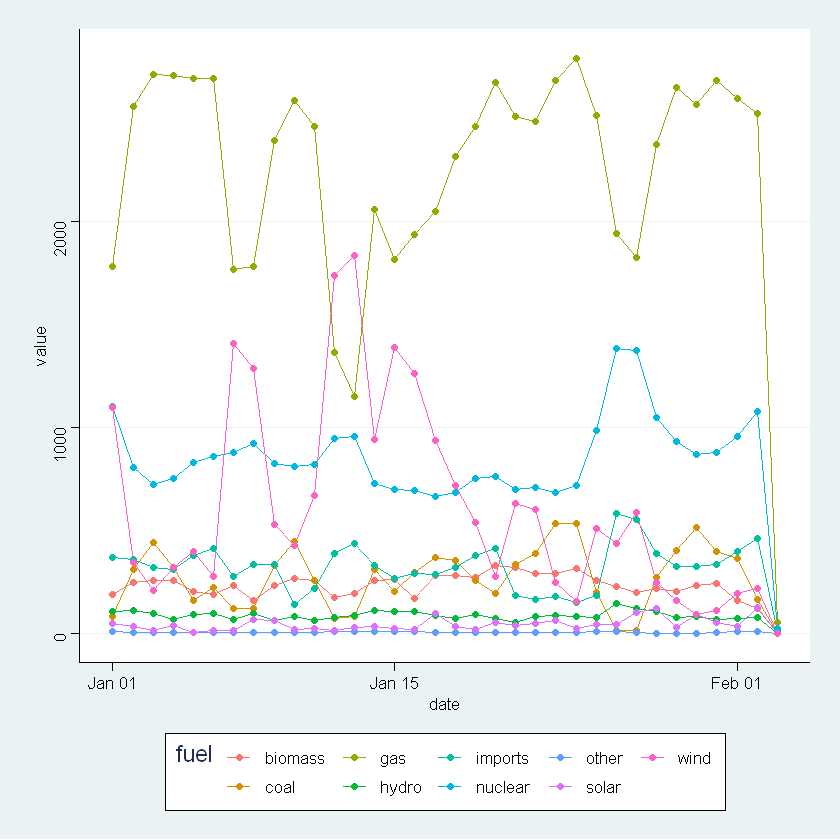

In [4]:
# plot line chart
df_long <- data_generation %>%
  pivot_longer(cols = -date, names_to = "fuel", values_to = "value")

generation_line <- ggplot(df_long, aes(x = date, y = value,color = fuel)) + geom_line() + geom_point() + theme_stata()
generation_line

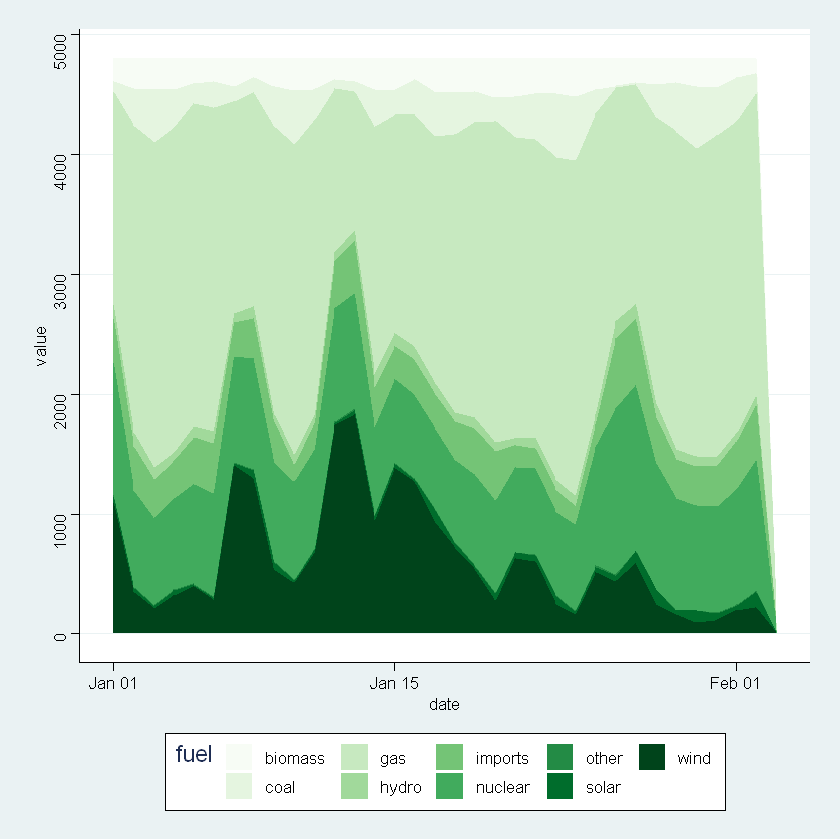

In [5]:
# plot stack chart
df_long <- data_generation %>%
  pivot_longer(cols = -date, names_to = "fuel", values_to = "value")

generation_stack <- ggplot(df_long, aes(x = date, y = value,fill = fuel)) + 
    geom_area() + 
    theme_stata() + 
    scale_fill_brewer(palette="Greens")
generation_stack

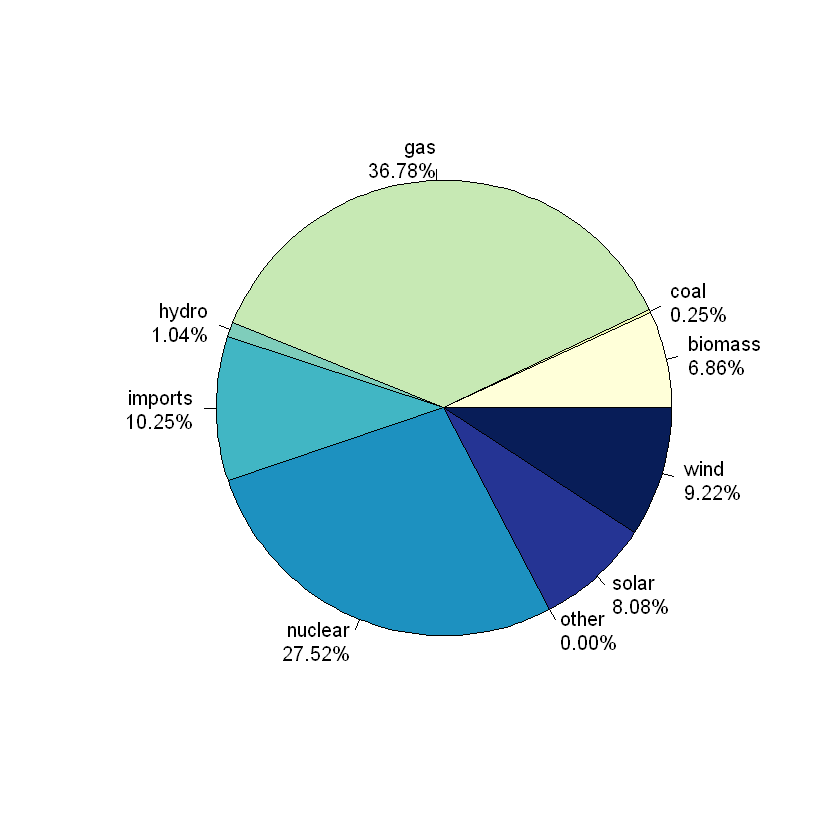

In [287]:
# plot pie chart
df_colSum <- colSums(data_generation[, -1], na.rm = TRUE)
df_colSum <- as.data.frame(t(df_colSum))
df_colSum_long <- pivot_longer(df_colSum, everything(), names_to = "Fuel", values_to = "Sum")
df_colSum_long <- df_colSum_long %>%
  mutate(Percentage = Sum / sum(Sum))


brewer_palette <- "YlGnBu"
palette_function <- brewer_pal(palette = brewer_palette)(length(df_colSum_long$Fuel))
percentage <- sprintf("%s\n%.2f%%", df_colSum_long$Fuel, df_colSum_long$Percentage * 100)
pie(df_colSum_long$Percentage, labels = percentage, col = palette_function)
#legend("top",legend = df_colSum_long$Fuel, fill = palette_function, horiz = TRUE)